### PyOD on the Big Mart Sales Problem

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [5]:
# reading the big mart sales training data
train = pd.read_csv("../data/example/big_mart_train.csv")
test = pd.read_csv("../data/example/big_mart_test.csv")

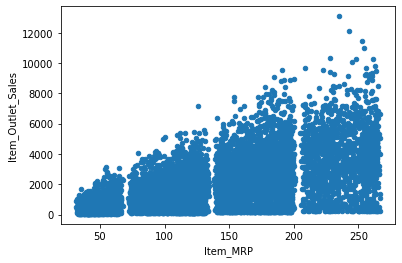

In [6]:
train.plot.scatter('Item_MRP','Item_Outlet_Sales')

The range of Item Outlet Sales is from 0 to 12000 and Item MRP is from 0 to 250. We will scale down both these features to a range between 0 and 1. This is required to create a explainable visualization (it will become way too stretched otherwise). As for this data, using the same approach will take much more time to create the visualization.

_Note: If you don’t want the visualization, you can use the same scale to predict whether a point is an outlier or not._

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(train[['Item_MRP','Item_Outlet_Sales']])
train[['Item_MRP','Item_Outlet_Sales']].head()

Item_MRP  Item_Outlet_Sales
0  0.927507           0.283587
1  0.072068           0.031419
2  0.468288           0.158115
3  0.640093           0.053555
4  0.095805           0.073651

In [10]:
# Store these values in the NumPy array for using in our models later:
X1 = train['Item_MRP'].values.reshape(-1,1)
X2 = train['Item_Outlet_Sales'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

Again, we will create a dictionary. But this time, we will add some more models to it and see how each model predicts outliers.

You can set the value of the outlier fraction according to your problem and your understanding of the data. In our example, I want to detect 5% observations that are not similar to the rest of the data. So, I’m going to set the value of outlier fraction as 0.05.

In [11]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05

In [12]:
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

OUTLIERS :  447 INLIERS :  8076 Angle-based Outlier Detector (ABOD)


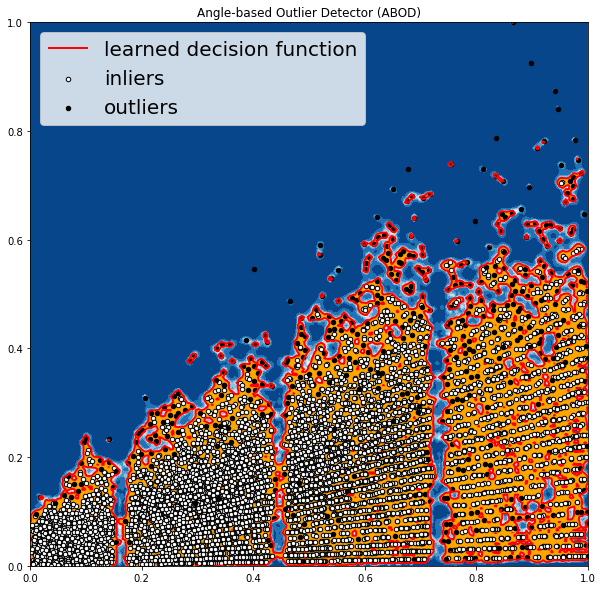

OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


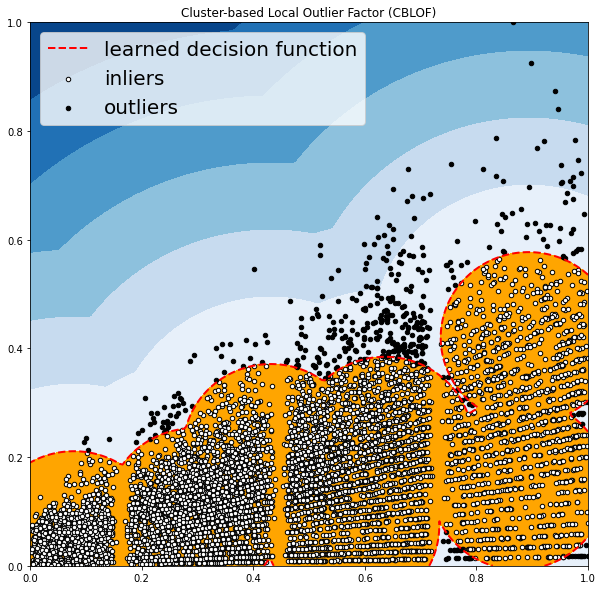

OUTLIERS :  369 INLIERS :  8154 Feature Bagging


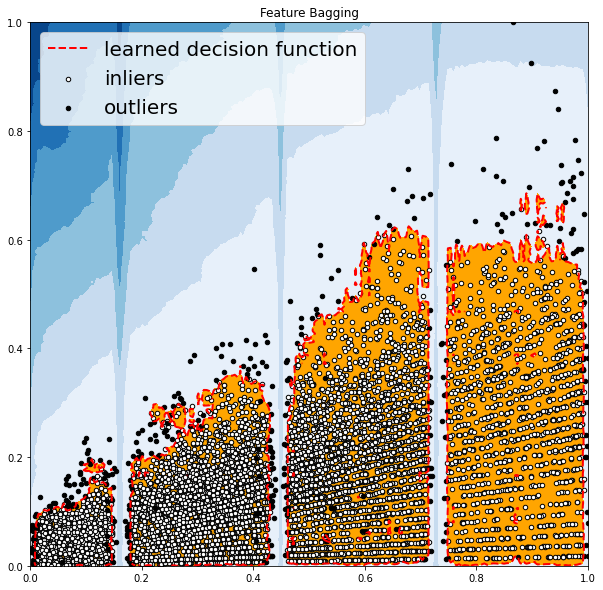

OUTLIERS :  501 INLIERS :  8022 Histogram-base Outlier Detection (HBOS)


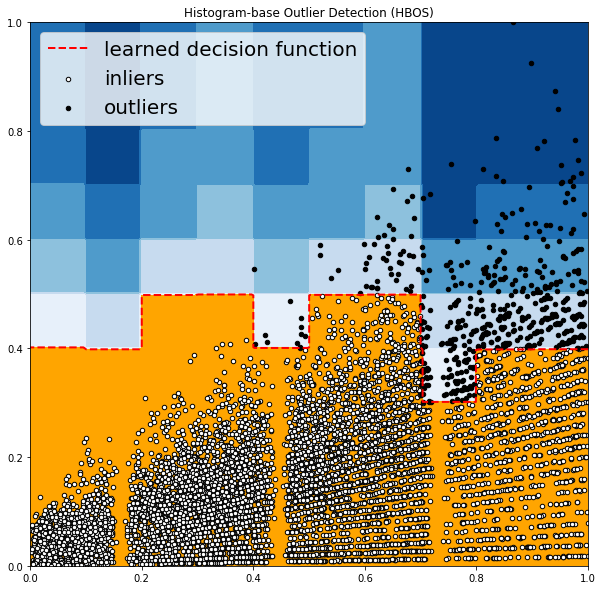

OUTLIERS :  427 INLIERS :  8096 Isolation Forest


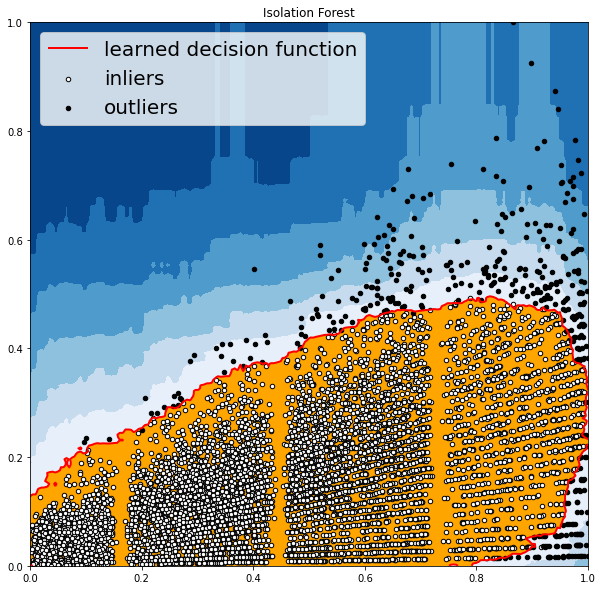

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


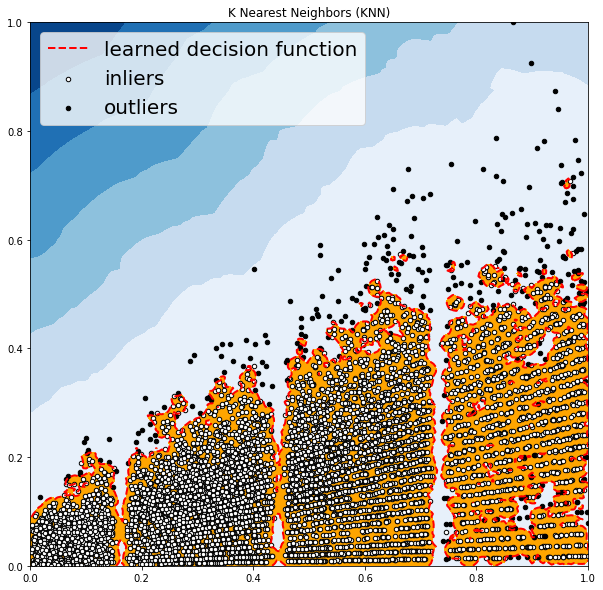

OUTLIERS :  176 INLIERS :  8347 Average KNN


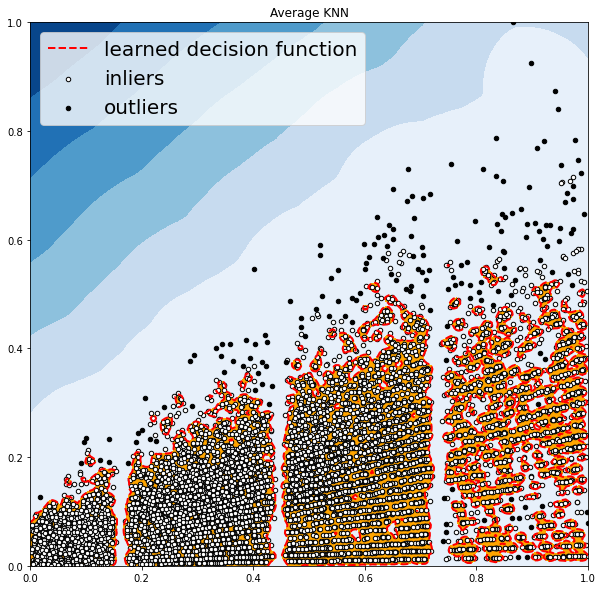

In [19]:
# Now, we will fit the data to each model one by one and see how differently each model predicts the outliers.
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    train_x = train
    train_x['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(train_x['Item_MRP'][train_x['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(train_x['Item_Outlet_Sales'][train_x['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  train_x['Item_MRP'][train_x['outlier'] == 1].values.reshape(-1,1)
    OX2 =  train_x['Item_Outlet_Sales'][train_x['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()